In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor



In [4]:
df = pd.read_csv('df.csv')
df.head()

,brand,flavour,volume_per_joghurt_g,packsize,product_id,Unnamed: 0,date,price,units,weekday,weight
0,Mueller,blueberry,150,6,0,0,2020-01-01,4.65,1126.0,Wednesday,1013400.0
1,Mueller,blueberry,150,6,0,1,2020-01-02,4.76,1205.0,Thursday,1084500.0
2,Mueller,blueberry,150,6,0,2,2020-01-03,5.22,1007.0,Friday,906300.0
3,Mueller,blueberry,150,6,0,3,2020-01-04,5.45,1282.0,Saturday,1153800.0
4,Mueller,blueberry,150,6,0,4,2020-01-05,3.33,1037.0,Sunday,933300.0


### baseline model: linear regression
in the etl we see there is a perfect linearity between unit and price, so let's fit a simple linear regression as base model


In [5]:
class linear_regression():

    def __init__(self):
        self.reg = None

    def pred(self, x):
        if self.reg is None:
            raise ValueError("train the model first")
        else:
            self.reg.predict(x)
            return self.reg.predict(x)
        
    def adjusted_r2(self, x, r2):
        n = x.shape[0]
        p = x.shape[1]
        adjusted_r2 = 1-(1-r2)*(n-1)/(n-p-1)
        return adjusted_r2
    
    def intercept(self):
        if self.reg is None:
            raise ValueError("train the model first")
        else:
            return self.reg.intercept_


    def linear_regression_on_units(self, x, y):



        #def y

        feature = x.columns.to_list()

        #skip standardization bcs comparing the feature on same scale is not as important as interpretablity here

        #test train split
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        #fit model
        self.reg  = LinearRegression()
        self.reg .fit(X_train, y_train)

        # predrict on test set
        y_pred = self.reg.predict(X_test)

        # metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        adj_r2 = self.adjusted_r2(x, r2)

        #coefficients
        reg_summary = pd.DataFrame(data=feature, columns=['Features'])
        reg_summary['Coefficients'] = self.reg .coef_.T    

        #check residuals
        y_hat = self.reg.predict(X_train)
        fig, ax = plt.subplots(1, 2)
        sns.histplot(y_train - y_hat, kde=True, ax=ax[0])
        sns.regplot(x=y_hat, y=(y_train - y_hat), ax=ax[1])

        print(f"coefficients: {reg_summary}")
        print(f"MSE: {mse:.3f}\n")
        print(f"R^2: {r2:.3f}\n")
        print(f"adjusted R^2: {adj_r2:.3f}\n")

  

coefficients:   Features  Coefficients
0    price   -139.562274
MSE: 83792.505

R^2: 0.572

adjusted R^2: 0.571



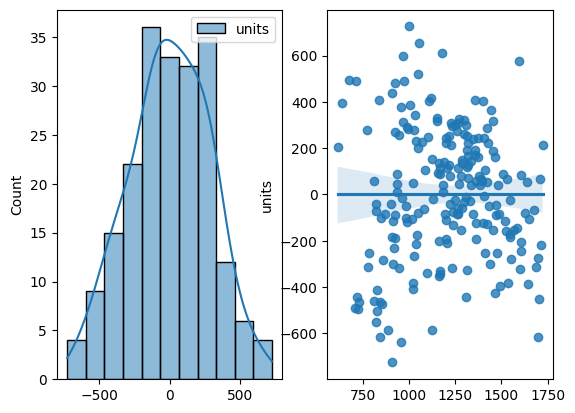

In [6]:
#base model
x1 = df[['price']]
y = df[['units']]
lr_x1 = linear_regression()
lr_x1.linear_regression_on_units(x1, y)

coefficients:                    Features  Coefficients
0                     price   -124.716529
1             brand_Activia    -97.453399
2            brand_Alnatura    183.160722
3              brand_Danone     55.633515
4   brand_Ecke-Mit-Was-Drin     95.434453
5                 brand_Ja!    100.758384
6             brand_Mueller    138.591729
7               brand_Oikos     69.398739
8                brand_Rewe    -34.134573
9         flavour_chocolate    311.647531
10        flavour_raspberry    -96.792038
11     flavour_straciatella    266.781168
12       flavour_strawberry    -21.105387
MSE: 58989.363

R^2: 0.699

adjusted R^2: 0.683



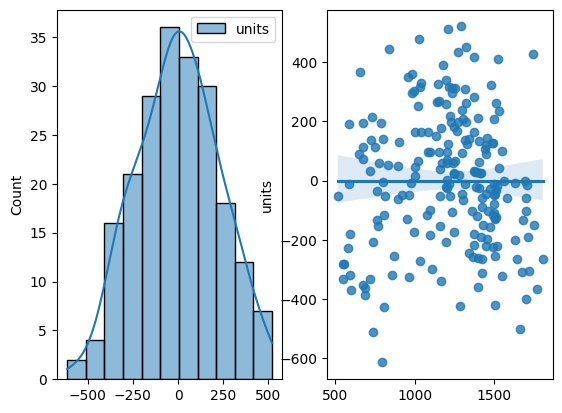

In [7]:
#base model with product features
#when the price increases by 1 euro, the sales will decrease by 102 unit
x2 = df[['brand', 'flavour', 'volume_per_joghurt_g', 'packsize', 'price']]
x3 = df[['brand', 'flavour',  'price']]

dummy_df = pd.get_dummies(x3, columns=['brand', 'flavour'], drop_first=True)
lr_xn = linear_regression()
lr_xn.linear_regression_on_units(dummy_df, y)

In [294]:
#checking multicollinearity
vif = pd.DataFrame()
x_list = dummy_df.columns.tolist()
vif["features"] = x_list
vif["VIF"] = [variance_inflation_factor(dummy_df[x_list].values, i) for i in range(len(x_list))]
vif

,features,VIF
0,price,7.538794
1,brand_Activia,1.880407
2,brand_Alnatura,2.566499
3,brand_Danone,2.674850
4,brand_Ecke-Mit-Was-Drin,2.447887
5,brand_Ja!,1.881867
6,brand_Mueller,2.817615
7,brand_Oikos,2.446164
8,brand_Rewe,2.725782
9,flavour_chocolate,2.163086


note on base model risk: 
- brand base line is Actimel, flavor baseline is blueberry
assumption for linear regression:
- linearity v
- endogeneity: can only assume Omitted variables/Simultaneity/Measurement error/ Sample selection bias doesn't exist
- normality and homoscedasticity of residual v
- autocorrelation: if the data are collected from different customers then it's safe otherwise this would lead to underestimate of std
- multicolinearity: price has a high VIF, which leads to inflated standard errors and biased estimation. since we are mainly looking at the effect of price affecting sales, 'volume_per_joghurt_g' and 'packsize' are dropped to increase the price precission even though it decrease adj r squared

### model: random forest

In [8]:
class random_forest():

    def __init__(self):
        self.reg = None

    def pred(self, x):
        if self.reg is None:
            raise ValueError("train the model first")
        else:
            self.reg.predict(x)
        return self.reg.predict(x)

    def random_forest_on_units(self, x):

        #def y
        y = df[['units']]


        #skip standardization bcs it's unnecessary for tree based models
        #test train split
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        #fit model
        self.reg = RandomForestRegressor(n_estimators=100, random_state=42)
        self.reg.fit(X_train, y_train)


        preds = self.reg.predict(X_test)

        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        


        print(f"MSE: {mse:.3f}\n")
        print(f"R^2: {r2:.3f}\n")
        print(self.reg.feature_importances_)





In [9]:
rf_x1 = random_forest()
rf_x1.random_forest_on_units(x1)

c:\Users\test\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 135833.616

R^2: 0.307

[1.]


In [10]:
rf_xn = random_forest()
rf_xn.random_forest_on_units(dummy_df)


c:\Users\test\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MSE: 41938.957

R^2: 0.786

[0.75513195 0.02226854 0.0085416  0.00991372 0.00610091 0.00729324
 0.03298408 0.01183795 0.01014182 0.05367989 0.00748972 0.06415384
 0.01046274]


notes on compariring both model:
- Cross-validation and scoring metrics like MSE or R² can be used to compare the generalization performance of multiple estimators.
- Adjusted R² is not well defined for non-parametric models like Random Forests.
- Standardizing the target variable allows MSE to be interpreted in terms of variance units, but it is no longer in the original units of measurement, making direct interpretability more difficult.
- R² depends only on the squared errors and the total variance, and both scale in the same way under standardization, R² remains unchanged

noted on random forest risk:
- n_estimators= 100 is the default value to balance of performance and speed A
- Independence of Observations: if the data is not collected from different customer this may lead to overfitting or misleading variable importance. Tree-based methods do not inherently account for autocorrelation... Time-series structure must be explicitly encoded via lag features or temporal validation
- minimal multicollinearity: may split on redundant variables/ misleading importance rankings. Random Forest is not affected by multicollinearity as much as linear regression... though variable importance can be biased.

- however the above 2 problems also affect linear model, and random forest is more robust to them in general. 

### price optimization

In [305]:
def generate_price_data(brand, flavour, price_range, df):


# simulation of price data for Müller and chocolate flavor
    base_case = df.min().copy()
    base_case[brand] = 1
    base_case[flavour] = 1

    price_list = []

    for price in price_range:
        row = base_case.copy()
        row['price'] = price
        price_list.append(row)



    return pd.DataFrame(price_list)
price_df = generate_price_data("brand_Mueller", "flavour_chocolate", np.linspace(1, 10, 100), dummy_df)

       price  brand_Activia  brand_Alnatura  brand_Danone  \
87  8.909091            0.0             0.0           0.0   

    brand_Ecke-Mit-Was-Drin  brand_Ja!  brand_Mueller  brand_Oikos  \
87                      0.0        0.0            1.0          0.0   

    brand_Rewe  flavour_chocolate  flavour_raspberry  flavour_straciatella  \
87         0.0                1.0                0.0                   0.0   

    flavour_strawberry  pred_unit       revenue  
87                 0.0    1146.16  10211.243636  


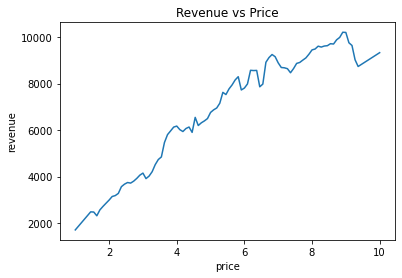

In [299]:
def revenue_optimize(price_df, model):
    revenue_df = price_df.copy()
    revenue_df['pred_unit'] = model.pred(price_df)
    revenue_df["revenue"] = revenue_df['pred_unit'] * revenue_df['price']
    print(revenue_df.query('revenue == revenue.max()'))
    sns.lineplot(data=revenue_df, x='price', y='revenue')
    plt.title("Revenue vs Price")
revenue_optimize(price_df, rf_xn)

       price  brand_Activia  brand_Alnatura  brand_Danone  \
83  8.545455            0.0             0.0           0.0   

    brand_Ecke-Mit-Was-Drin  brand_Ja!  brand_Mueller  brand_Oikos  \
83                      0.0        0.0            1.0          0.0   

    brand_Rewe  flavour_chocolate  flavour_raspberry  flavour_straciatella  \
83         0.0                1.0                0.0                   0.0   

    flavour_strawberry    pred_unit      revenue  
83                 0.0  1057.195835  9034.218955  


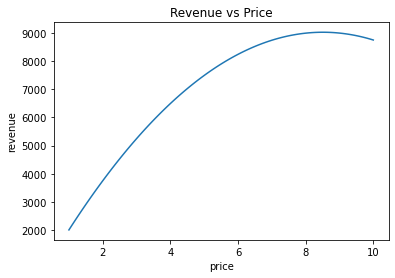

In [300]:
revenue_optimize(price_df, lr_xn)

### result 
according to random forest, setting price at 8.9 will maximize the revenure for chocolate jogurt from brand Müller, while linear model suggests a similar price at 8.54

### potential next step 
- AB testing result
- better fitting model e.g. gradient boosting tree
- more data e.g. geo location store, competitor pricing

coefficients:                    Features  Coefficients
0                     price     -0.590476
1             brand_Activia      0.011550
2            brand_Alnatura      0.406982
3              brand_Danone      0.147515
4   brand_Ecke-Mit-Was-Drin      0.213977
5                 brand_Ja!      0.232849
6             brand_Mueller      0.351342
7               brand_Oikos      0.251688
8                brand_Rewe      0.029662
9         flavour_chocolate      0.287369
10        flavour_raspberry     -0.168992
11     flavour_straciatella      0.272457
12       flavour_strawberry     -0.112038
MSE: 0.508

R^2: 0.332

adjusted R^2: 0.297



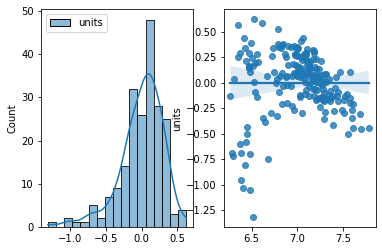

In [ ]:
#extra, i also fit a log-log model and based on r squared we know the linear model is a way better choice as the graph suggests
df_log = df.copy()
df_log["price"] = np.log(df["price"])
df_log["units"] = np.log(df["units"])

x4 = df_log[['brand', 'flavour',  'price']]
y = df_log[['units']]
df_log_dummy = pd.get_dummies(x4, columns=['brand', 'flavour'], drop_first=True)

lr_pe = linear_regression()
lr_pe.linear_regression_on_units(df_log_dummy, y)

In [1]:
# model comparison for this dataset

### OLS

- linearity v
- endogeneity: can only assume Omitted variables/Simultaneity/Measurement error/ Sample selection bias doesn't exist
- normality and homoscedasticity of residual v
- autocorrelation: if the data are collected from different customers then it's safe otherwise this would lead to underestimate of std
- multicolinearity: price has a high VIF, which leads to inflated standard errors and biased estimation. since we are mainly looking at the effect of price affecting sales, 'volume_per_joghurt_g' and 'packsize' are dropped to increase the price precission even though it decrease adj r squared



### model: random forest

- n_estimators= 100 is the default value to balance of performance and speed A
- Independence of Observations: if the data is not collected from different customer this may lead to overfitting or misleading variable importance. Tree-based methods do not inherently account for autocorrelation... Time-series structure must be explicitly encoded via lag features or temporal validation
- minimal multicollinearity: may split on redundant variables/ misleading importance rankings. Random Forest is not affected by multicollinearity as much as linear regression... though variable importance can be biased.

- however the above 2 problems also affect linear model, and random forest is more robust to them in general. 

### comparing random forest and OLS

- Cross-validation and scoring metrics like MSE or R² can be used to compare the generalization performance of multiple estimators.
- Adjusted R² is not well defined for non-parametric models like Random Forests.
- Standardizing the target variable allows MSE to be interpreted in terms of variance units, but it is no longer in the original units of measurement, making direct interpretability more difficult.
- R² depends only on the squared errors and the total variance, and both scale in the same way under standardization, R² remains unchanged

### other alternatives

- **gradient boosting tree regresssion :**

    potentoal of higher accuracy than random forest, but requires more tuning and is more prone to overfitting

- **GLM :** generalizes OLS by allowing for non-normal dependent variables (e.g., logistic regression, Poisson regression). It is best when the data type itself is different—like counts or proportions.
    - Linearity 
    - No Endogeneity 
    - No Multicollinearity 
    - No Autocorrelation

    specific to GLM compared to OLS:
    - Correct Specification of the Link Functio
    - Correct Specification of the Distribution of the Response Variable (exponential family e.g., Normal, Binomial, Poisson, Gamma, Inverse Gaussian)
    - Some GLMs require handling of an extra dispersion parameter (e.g., in Gamma or quasi-Poisson models).

    difference from OLS, GLM can better handle the below assumptions, but we don't have to worry about them here:
    - Normality and Homoscedasticity of Residuals
        - Normality: GLM assumes that the response variable follows a distribution from the exponential family
        - Homoscedasticity : GLM allows the variance to be a function of the mean, depending on the family 

- **GLS :**  generalizes OLS by relaxing the assumption of homoscedasticity and uncorrelated errors. It is used when the dependent variable is continuous and normally distributed, but errors are problematic (e.g., heteroscedastic or autocorrelated)   
    - Linearity 
    - No Endogeneity 
    - No Multicollinearity 

    specific to GLS compared to OLS:
    - Known or Correctly Specified Error Variance-Covariance Matrix (Ω)
        - use GLS If Ω is known
        - use Feasible GLS if Ω must be estimated

    difference from OLS, GLS can better handle the below assumptions, but we don't have to worry about them here:
    - Normality and Homoscedasticity of Residuals
        - Normality: Not necessary for unbiasedness/consistency, only for inference
        - Homoscedasticity : GLS is used precisely when heteroscedasticity is present
    - No Autocorrelation : GLS is often employed specifically to address autocorrelation 

- **GAM :** Generalized Additive Models 
    - No Endogeneity 
    - No Multicollinearity 
    - No Autocorrelation	

    specific to GAM compared to OLS:
    - Smoothness Selection & Overfitting Control: GAMs require selecting the degree of smoothness for each function (e.g., via penalized likelihood)
    - Basis Function Specification: GAM is sensitive to the choice and number of basis functions used to represent smooth terms.
    - Additivity: GAM assumes that effects of predictors are additive, unless interactions are explicitly modeled.



    difference from OLS, GAM can better handle the below assumptions:
     - Linearity: Predictors are allowed to have non-linear relationships with the response via smooth functions (e.g., splines). 
    - Normality and Homoscedasticity of Residuals
        - Normality: Required only if using Gaussian family, not required for all GAMs (GAMs can use Poisson, binomial, etc.)
        - Homoscedasticity: Assumes variance is correctly modeled via the distribution in the specified family; for Gaussian GAMs, this implies constant variance unless otherwise modeled

    here maybe GAM can fit a better line than OLS, but the difference can't be too drastic based on the graph


SyntaxError: unterminated string literal (detected at line 6) (2182160986.py, line 6)